# Diffusion Augmentation (Oxford-IIIT Pet) — Colab notebook

В ноутбуке два режима:

**A. Мини‑демо диффузионных аугментаций (без обучения):**
- **text2img** — генерация картинки по тексту;
- **img2img** — небольшие правки (поза/ракурс);
- **inpaint background** — замена фона по *trimap* сегментации.

**B. Полный эксперимент «Diffusion Augmentation»:**
1) обучаем baseline‑классификатор;
2) выбираем «проблемные» классы по confusion matrix;
3) генерируем синтетику только для этих классов;
4) фильтруем качество (CLIP/pHash/простая статистика);
5) сравниваем **REAL** vs **REAL+SYN** в режиме *step‑matched* (одинаковое число шагов обучения).


In [1]:
!nvidia-smi -L
import torch
print('torch', torch.__version__, 'cuda', torch.cuda.is_available())

GPU 0: Tesla T4 (UUID: GPU-47f56f95-9225-9280-1076-acc5cde4ffbf)
torch 2.9.0+cu126 cuda True


## 0) Подключаем репозиторий



In [2]:
!git clone https://github.com/qskzx/DiffusionAugmentations.git
%cd DiffusionAugmentations

Cloning into 'DiffusionAugmentations'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 54 (delta 13), reused 40 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (54/54), 24.44 KiB | 12.22 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/content/DiffusionAugmentations


## 1) Установка зависимостей

In [3]:
!pip -q install -r requirements-colab.txt
!pip -q install -e .
!pip -q uninstall -y xformers >/dev/null 2>&1 || true

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.9/504.9 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 101.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for diffaug-pets (pyproject.toml) ... done


## 2) Конфиг, устройство, сид

- `finalize_cfg(...)` приводит параметры к «безопасным» значениям (например, размер генерации кратен 8) и создаёт рабочие директории.
- `seed_everything(...)` фиксирует рандом для воспроизводимости.


In [4]:
from pathlib import Path
import numpy as np
from diffaug_pets.config import CFG, finalize_cfg
from diffaug_pets.logging_utils import silence_hf_warnings
from diffaug_pets.utils.seed import get_device, seed_everything, cleanup, set_tf32_if_cuda
from diffaug_pets.data.pets import load_raw_pets, build_species_by_breed,norm_breed, stratified_split, PetsMattingSubset
from diffaug_pets.diffusion.pipes import load_pipes
from diffaug_pets.aug.augmenter import Augmenter
from diffaug_pets.vis.grids import visualize_selectors_or_random

silence_hf_warnings()
cfg = finalize_cfg(CFG())
cfg.data_root = "/content/data"
cfg.work_dir = "/content/work"
device = get_device()
set_tf32_if_cuda(device)
seed_everything(cfg.seed)
print("DEVICE:", device)

data_root = Path(cfg.data_root)
ds_train, ds_test = load_raw_pets(data_root)
class_names = ds_train.classes
labels = [y for _, (y, _) in ds_train]
train_idx, _val_idx = stratified_split(labels=np.array(labels), seed=cfg.seed, train_frac=0.85)
mat_ds = PetsMattingSubset(ds_train, train_idx)

breed2species = build_species_by_breed(data_root)
def species_token_fn(class_name):
    return breed2species.get(norm_breed(class_name), "pet")

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


DEVICE: cuda


100%|██████████| 792M/792M [00:06<00:00, 123MB/s] 
100%|██████████| 19.2M/19.2M [00:00<00:00, 117MB/s] 


## 3) Загружаем 3 диффузионных пайплайна
- **Text2Image**: генерация с нуля
- **Image2Image**: «малые правки» (вариации позы/света)
- **Inpainting**: замена фона по маске


In [5]:
import inspect
print(inspect.getsource(load_pipes))

@torch.no_grad()
def load_pipes(t2i_model: str, i2i_model: str, inpaint_model: str, device: str) -> Pipes:
    dtype = torch.float16 if device == "cuda" else torch.float32
    t2i = AutoPipelineForText2Image.from_pretrained(
        t2i_model, torch_dtype=dtype,
        safety_checker=None, requires_safety_checker=False,
        use_safetensors=True,
        variant=("fp16" if device == "cuda" else None),
    )
    i2i = AutoPipelineForImage2Image.from_pretrained(
        i2i_model, torch_dtype=dtype,
        safety_checker=None, requires_safety_checker=False,
        use_safetensors=True,
        variant=("fp16" if device == "cuda" else None),
    )
    inp = AutoPipelineForInpainting.from_pretrained(
        inpaint_model, torch_dtype=dtype,
        safety_checker=None, requires_safety_checker=False,
        use_safetensors=False,
        variant=("fp16" if device == "cuda" else None),
    )
    return Pipes(
        t2i=tune_pipe(t2i, device),
        i2i=tune_pipe(i2i, device),
   

In [6]:
pipes = load_pipes(cfg.t2i_model, cfg.i2i_model, cfg.inpaint_model, device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/1.72G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

text_encoder/pytorch_model.fp16.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

## 4) Augmenter: промпты + retry‑логика + matting

`Augmenter` инкапсулирует три операции аугментации.

Дополнительно:
- `conf_map` (из confusion matrix) используется для **negative prompt** вида *"not a ..."*, чтобы модель реже уходила в «похожие породы».
- `species_token_fn` добавляет токен `cat`/`dog` в промпт (полезно для устойчивости).



In [7]:
conf_map = {}
augmenter = Augmenter(cfg=cfg, device=device, class_names=class_names, conf_map=conf_map, species_token_fn=species_token_fn, pipes=pipes)

## 5) Демо 1: Text‑to‑Image (генерация «с нуля»)
Выбираем породу, печатаем prompt/negative prompt и генерируем несколько вариантов по разным seed.


PROMPT:
 a high-quality realistic photo of a Abyssinian cat on a grassy field, sharp focus, natural lighting

NEG:
 human, person, people, face, hands, body, skin, text, watermark, logo, signature, low quality, blurry, out of focus, distorted, deformed, bad anatomy, extra limbs, extra fingers, mutated, cartoon, painting, illustration, toy


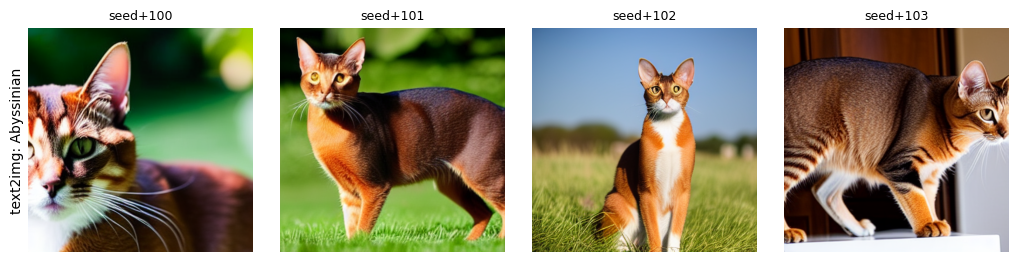

In [18]:
from diffaug_pets.vis.lecture_grid import show_grid
from diffaug_pets.aug.prompts import class_prompt, neg_with_confusables

# Pick a class to demo
demo_class = "Abyssinian"
name2idx = {n.replace("_"," ").casefold(): i for i,n in enumerate(class_names)}
y = name2idx[demo_class.replace("_"," ").casefold()]

prompt = class_prompt(class_names[y], species_token_fn)
neg = neg_with_confusables(y, class_names, conf_map)

print("PROMPT:\n", prompt)
print("\nNEG:\n", neg)

imgs = [augmenter.text2img(class_idx=y, seed=cfg.seed + 100 + k) for k in range(4)]

show_grid(
    rows=[imgs],
    row_titles=[f"text2img: {class_names[y]}"],
    col_titles=[f"seed+{100+k}" for k in range(4)],
)



## 6) Демо 2: Image‑to‑Image (малые правки)
Берём реальное изображение породы и делаем «малые правки» через image‑to‑image.

Параметр `strength`:
- меньше → ближе к оригиналу,
- больше → сильнее изменения.


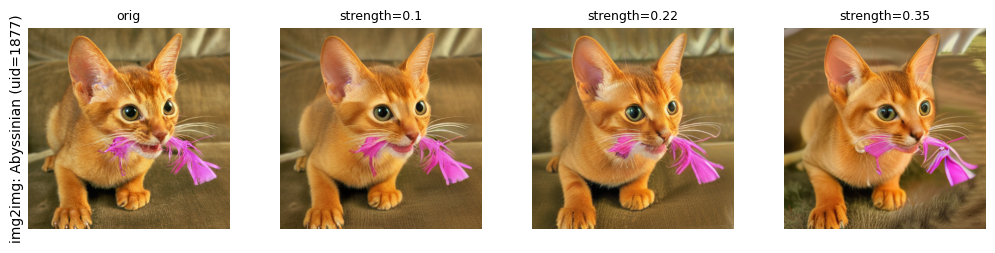

In [27]:
import random

# pick a real image of that class
idxs = [i for i in range(len(mat_ds)) if int(mat_ds[i][2]) == int(y)]
i = random.choice(idxs)
img, trimap, y_img, uid = mat_ds[i]

strengths = [0.10, 0.22, 0.35]
outs = [img.resize((cfg.gen_size, cfg.gen_size))]
for s in strengths:
    cfg_old = cfg.strength_small_edits
    cfg.strength_small_edits = float(s)
    outs.append(augmenter.small_edit(img=img, class_idx=y_img, seed=cfg.seed + int(1000*s)))
    cfg.strength_small_edits = cfg_old

show_grid(
    rows=[outs],
    row_titles=[f"img2img: {class_names[y_img]} (uid={uid})"],
    col_titles=["orig"] + [f"strength={s}" for s in strengths],
)



## 7) Демо 3: Inpainting background (замена фона по trimap)
Строим маску фона из trimap → inpaint → затем композитим: оставляем исходное животное, подставляем новый фон.


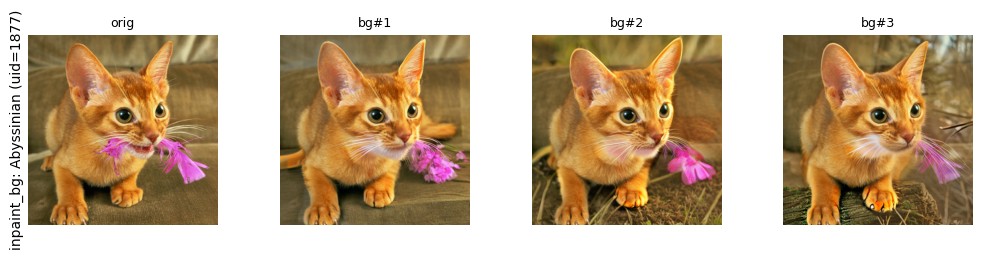

In [72]:
from diffaug_pets.aug.matting import mask_background_from_trimap, trimap_to_fg_alpha
import matplotlib.pyplot as plt

idxs = [i for i in range(len(mat_ds)) if int(mat_ds[i][2]) == int(y)]
i = random.choice(idxs)
img, trimap, y_img, uid = mat_ds[i]
# Visualize mask/alpha
mask = mask_background_from_trimap(trimap, dilate=2).resize((cfg.gen_size, cfg.gen_size))
alpha = trimap_to_fg_alpha(trimap, size=cfg.gen_size, feather=3)


# Inpaint BG
outs = [img.resize((cfg.gen_size, cfg.gen_size))]
for k in range(3):
    outs.append(augmenter.inpaint_background(img=img, trimap=trimap, class_idx=y_img, seed=cfg.seed  +100+ k))

show_grid(
    rows=[outs],
    row_titles=[f"inpaint_bg: {class_names[y_img]} (uid={uid})"],
    col_titles=["orig","bg#1","bg#2","bg#3"],
)


## 8) Полный эксперимент: baseline → target classes → синтетика → фильтр → step‑matched

Ниже — воспроизводимый pipeline:

1. **Baseline‑классификатор** на реальных данных.
2. **Target classes**: выбираем классы с наибольшим числом ошибок.
3. **Генерация синтетики** только для target‑классов:
   - inpaint_bg / small_edit / text2img.
4. **Фильтрация качества**: CLIP‑margin, pHash‑дедуп, простые эвристики.
5. **Step‑matched сравнение** (REAL vs MIX) — одинаковое число шагов обучения.
- **REAL**: только реальные изображения Oxford‑IIIT Pet
- **MIX**: реальные + *немного* синтетики (целенаправленно для «сложных» классов)

Метрики:
- `acc`, `f1_macro` — качество на *всех* 37 классах
- `target_acc`, `target_f1_macro` — качество **только на выбранных “problem classes”** (`TARGET_SET`)

💡 Советы:
- Manifests кэшируются в `work/manifests`, поэтому повторный запуск обычно быстрее.
- Если не хватает VRAM, можно освобождать диффузионные пайпы между этапами (см. ячейку «Free VRAM» ниже).


## (Опционально) Освобождаем VRAM перед обучением

Диффузионные пайпы большие. Если дальше будете обучать/оценивать классификатор на GPU, безопаснее удалить пайпы и `augmenter`, а потом снова загрузить их перед генерацией синтетики.


In [ ]:
# Free VRAM / RAM before classifier training
#try:
#    del t2i_pipe, i2i_pipe, inpaint_pipe
#except Exception:
#    pass
#try:
#    del pipes
#except Exception:
#    pass
#try:
#    del augmenter
#except Exception:
#    pass

#cleanup()

#import torch
#if torch.cuda.is_available():
#    print("allocated:", round(torch.cuda.memory_allocated()/1024**3, 4), "GB")
#    print("reserved :", round(torch.cuda.memory_reserved()/1024**3, 4), "GB")

### Настройка гиперпараметров для эксперимента


In [73]:
cfg.img_size = 224
cfg.batch_size = 64
cfg.num_workers = 0
cfg.epochs = 3
cfg.lr = 3e-4
cfg.weight_decay = 1e-4
cfg.model_name = "resnet18"
cfg.top_n_targets = 10


### Сплиты и даталоадеры



In [74]:
from diffaug_pets.data.pets import PetsSubset, build_transforms, make_loader, stratified_split

train_tf, val_tf = build_transforms(cfg.img_size)

labels = np.array([y for _, (y, _) in ds_train])
train_idx, val_idx = stratified_split(labels, seed=cfg.seed, train_frac=0.85)

train_ds = PetsSubset(ds_train, train_idx, tf=train_tf)
val_ds   = PetsSubset(ds_train, val_idx,   tf=val_tf)
test_ds  = PetsSubset(ds_test,  np.arange(len(ds_test)), tf=val_tf)

train_dl = make_loader(train_ds, cfg.batch_size, shuffle=True,  num_workers=cfg.num_workers)
val_dl   = make_loader(val_ds,   cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
test_dl  = make_loader(test_ds,  cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

print(len(train_ds), len(val_ds), len(test_ds))


3126 554 3669


### 1) Baseline: обучаем классификатор и получаем confusion matrix

Baseline нужен, чтобы:
1) найти классы, которые путаются сильнее всего → выберем `TARGET_SET`;
2) построить `conf_map` для **negative prompts** в диффузии (“not a …” для похожих пород).

После обучения мы печатаем список `TARGET_SET` (названия пород). Именно для них будем генерировать синтетику.


In [75]:
import torch
import torch.nn as nn

from diffaug_pets.models.classifier import Classifier
from diffaug_pets.train.baseline import (
    train_one_epoch, evaluate_with_cm,
    select_target_classes, build_conf_map
)
K=37

baseline = Classifier(num_classes=37, backbone=cfg.model_name).to(device)
opt = torch.optim.AdamW(baseline.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
loss_fn = nn.CrossEntropyLoss()

for ep in range(cfg.epochs):
    tr_loss = train_one_epoch(baseline, train_dl, opt, loss_fn, device=device)
    va = evaluate_with_cm(baseline, val_dl, num_classes=K, device=device)
    print(f"ep {ep+1}: train_loss={tr_loss:.4f} | val_acc={va['acc']:.3f} | val_f1={va['f1_macro']:.3f}")

target_classes, errors, err_rate = select_target_classes(va["cm"], top_n=cfg.top_n_targets)
TARGET_SET = set(map(int, target_classes))
conf_map = build_conf_map(va["cm"], per_class=3)

print("TARGET_SET:", [class_names[i] for i in target_classes])

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ep 1: train_loss=3.3293 | val_acc=0.583 | val_f1=0.552


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ep 2: train_loss=2.1624 | val_acc=0.818 | val_f1=0.812


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ep 3: train_loss=1.1874 | val_acc=0.854 | val_f1=0.852
TARGET_SET: ['American Pit Bull Terrier', 'Boxer', 'Russian Blue', 'English Setter', 'Ragdoll', 'Shiba Inu', 'Saint Bernard', 'Beagle', 'Bengal', 'Chihuahua']


### Загружаем diffusion pipes и собираем `Augmenter`

Здесь `conf_map` уже **не пустой** и реально используется при сборке negative prompt.


In [76]:
augmenter.conf_map = conf_map

### 3) Генерация синтетики + manifest

Для каждой техники:
- генерируем изображения;
- сохраняем их на диск;
- записываем manifest (CSV) со столбцами `path`, `y`, `method`, `uid`, `seed`.



In [77]:
from pathlib import Path
from diffaug_pets.data.pets import PetsMattingSubset
from diffaug_pets.synth.manifests import (
    load_or_make,
    generate_manifest_inpaint_bg,
    generate_manifest_small_edit,
    generate_manifest_text2img,
)

# mat_ds нужен для inpaint_bg + small_edit (берём реальные картинки + trimap)
mat_ds = PetsMattingSubset(ds_train, train_idx)

WORK = Path(cfg.work_dir)
MAN_DIR = WORK / "manifests"
SYN_ROOT = WORK / "synthetic_targeted"
MAN_DIR.mkdir(parents=True, exist_ok=True)
SYN_ROOT.mkdir(parents=True, exist_ok=True)

# 1) INPAINT_BG
df_bg = load_or_make(
    MAN_DIR / "gen_inpaint_bg.csv",
    lambda: generate_manifest_inpaint_bg(
        augmenter=augmenter,
        mat_ds=mat_ds,
        class_names=class_names,
        target_classes=list(TARGET_SET),
        syn_root=SYN_ROOT,
        base_seed=cfg.seed,
        n_seed_images_per_class=cfg.n_seed_images_per_class,
        n_variations_per_seed=cfg.n_variations_per_seed,
    )
)

# 2) SMALL_EDIT
df_se = load_or_make(
    MAN_DIR / "gen_small_edit.csv",
    lambda: generate_manifest_small_edit(
        augmenter=augmenter,
        mat_ds=mat_ds,
        class_names=class_names,
        target_classes=list(TARGET_SET),
        syn_root=SYN_ROOT,
        base_seed=cfg.seed,
        n_seed_images_per_class=cfg.n_seed_images_per_class,
        n_variations_per_seed=cfg.n_variations_per_seed,
    )
)

# 3) TEXT2IMG
df_t2 = load_or_make(
    MAN_DIR / "gen_text2img.csv",
    lambda: generate_manifest_text2img(
        augmenter=augmenter,
        class_names=class_names,
        target_classes=list(TARGET_SET),
        syn_root=SYN_ROOT,
        base_seed=cfg.seed,
        n_text2img_per_class=cfg.n_text2img_per_class,
    )
)

print("Generated:", len(df_bg), len(df_se), len(df_t2))


Generated: 60 60 60


### 4) Фильтрация синтетики (качество + дубликаты)

Фильтрация уменьшает шум:
- **std‑фильтр** — отсекает “почти чёрные/пустые” кадры
- **pHash** — удаляет near‑duplicates
- **CLIP margin** — проверяет, что изображение ближе к своему классу, чем к путаемым
- `keep_per_class` — ограничивает число синтетики на класс


In [78]:
from diffaug_pets.metrics.clip_filter import FilterCfg, filter_manifest

fcfg = FilterCfg(
    min_std=float(cfg.min_std),
    phash_hamming_thr=int(cfg.phash_hamming_thr),
    clip_margin_thr=float(cfg.clip_margin_thr),
    clip_own_min=float(cfg.clip_own_min),
    keep_per_class=int(cfg.keep_per_class),
)

df_bg_f = filter_manifest(df_bg, device=device, class_names=class_names, conf_map=conf_map,
                         species_token_fn=species_token_fn, clip_model_name=cfg.clip_model_name, fcfg=fcfg)
df_se_f = filter_manifest(df_se, device=device, class_names=class_names, conf_map=conf_map,
                         species_token_fn=species_token_fn, clip_model_name=cfg.clip_model_name, fcfg=fcfg)
df_t2_f = filter_manifest(df_t2, device=device, class_names=class_names, conf_map=conf_map,
                         species_token_fn=species_token_fn, clip_model_name=cfg.clip_model_name, fcfg=fcfg)

df_bg_f.to_csv(MAN_DIR / "filt_inpaint_bg.csv", index=False)
df_se_f.to_csv(MAN_DIR / "filt_small_edit.csv", index=False)
df_t2_f.to_csv(MAN_DIR / "filt_text2img.csv", index=False)

print("filtered:", len(df_bg_f), len(df_se_f), len(df_t2_f))


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

filtered: 16 8 17


### 5) Step‑matched эксперимент (REAL vs MIX)

Делаем три прогона: `INPAINT_BG`, `SMALL_EDIT`, `TEXT2IMG`.


In [79]:
import pandas as pd
from diffaug_pets.train.step_matched import run_step_matched

def model_ctor():
    from diffaug_pets.models.classifier import Classifier
    return Classifier(num_classes=K, backbone=cfg.model_name)

results = []

use_bg = df_bg_f

teR, teM, steps, n_syn, n_mix = run_step_matched(
    num_classes=K,
    model_ctor=model_ctor,
    train_real_ds=train_ds,
    val_ds=val_ds,
    test_ds=test_ds,
    train_tf=train_tf,
    syn_df=use_bg,
    cfg=cfg,
    target_set=TARGET_SET,
    device=device,
    title="INPAINT_BG",
)
results.append({"method":"inpaint_bg","steps":steps,"n_syn":n_syn,"n_mix":n_mix, **{f"real_{k}":v for k,v in teR.items()}, **{f"mix_{k}":v for k,v in teM.items()}})


=== INPAINT_BG (STEP-MATCHED) ===
Total steps BOTH = 150 (eval_every=25) | syn=16 | mix=3142

--- REAL ---
Step 25/150 | val_acc=0.321 | val_f1=0.263 | target_acc=0.140 | target_f1=0.180
Step 50/150 | val_acc=0.675 | val_f1=0.662 | target_acc=0.567 | target_f1=0.667
Step 75/150 | val_acc=0.787 | val_f1=0.783 | target_acc=0.667 | target_f1=0.747
Step 100/150 | val_acc=0.810 | val_f1=0.804 | target_acc=0.613 | target_f1=0.708
Step 125/150 | val_acc=0.863 | val_f1=0.858 | target_acc=0.727 | target_f1=0.795
Step 150/150 | val_acc=0.866 | val_f1=0.868 | target_acc=0.780 | target_f1=0.855
TEST REAL | acc=0.821 | f1=0.823 | target_acc=0.744 | target_f1=0.837

--- MIX ---
Step 25/150 | val_acc=0.379 | val_f1=0.347 | target_acc=0.227 | target_f1=0.307
Step 50/150 | val_acc=0.661 | val_f1=0.637 | target_acc=0.640 | target_f1=0.676
Step 75/150 | val_acc=0.810 | val_f1=0.809 | target_acc=0.687 | target_f1=0.782
Step 100/150 | val_acc=0.852 | val_f1=0.848 | target_acc=0.693 | target_f1=0.781
Step 

In [84]:
use_se = df_se_f

teR, teM, steps, n_syn, n_mix = run_step_matched(
    num_classes=K,
    model_ctor=model_ctor,
    train_real_ds=train_ds,
    val_ds=val_ds,
    test_ds=test_ds,
    train_tf=train_tf,
    syn_df=use_se,
    cfg=cfg,
    target_set=TARGET_SET,
    device=device,
    title="SMALL_EDIT",
)
results.append({"method":"small_edit","steps":steps,"n_syn":n_syn,"n_mix":n_mix, **{f"real_{k}":v for k,v in teR.items()}, **{f"mix_{k}":v for k,v in teM.items()}})


=== SMALL_EDIT (STEP-MATCHED) ===
Total steps BOTH = 147 (eval_every=25) | syn=8 | mix=3134

--- REAL ---
Step 25/147 | val_acc=0.264 | val_f1=0.213 | target_acc=0.187 | target_f1=0.201
Step 50/147 | val_acc=0.626 | val_f1=0.600 | target_acc=0.487 | target_f1=0.564
Step 75/147 | val_acc=0.789 | val_f1=0.786 | target_acc=0.660 | target_f1=0.756
Step 100/147 | val_acc=0.816 | val_f1=0.816 | target_acc=0.713 | target_f1=0.798
Step 125/147 | val_acc=0.850 | val_f1=0.848 | target_acc=0.687 | target_f1=0.793
Step 147/147 | val_acc=0.841 | val_f1=0.837 | target_acc=0.680 | target_f1=0.751
TEST REAL | acc=0.816 | f1=0.812 | target_acc=0.743 | target_f1=0.821

--- MIX ---
Step 25/147 | val_acc=0.329 | val_f1=0.281 | target_acc=0.267 | target_f1=0.324
Step 50/147 | val_acc=0.650 | val_f1=0.653 | target_acc=0.567 | target_f1=0.660
Step 75/147 | val_acc=0.782 | val_f1=0.776 | target_acc=0.740 | target_f1=0.819
Step 100/147 | val_acc=0.859 | val_f1=0.860 | target_acc=0.820 | target_f1=0.886
Step 1

In [85]:
use_t2 = df_t2_f

teR, teM, steps, n_syn, n_mix = run_step_matched(
    num_classes=K,
    model_ctor=model_ctor,
    train_real_ds=train_ds,
    val_ds=val_ds,
    test_ds=test_ds,
    train_tf=train_tf,
    syn_df=use_t2,
    cfg=cfg,
    target_set=TARGET_SET,
    device=device,
    title="TEXT2IMG",
)
results.append({"method":"text2img","steps":steps,"n_syn":n_syn,"n_mix":n_mix, **{f"real_{k}":v for k,v in teR.items()}, **{f"mix_{k}":v for k,v in teM.items()}})


=== TEXT2IMG (STEP-MATCHED) ===
Total steps BOTH = 150 (eval_every=25) | syn=17 | mix=3143

--- REAL ---
Step 25/150 | val_acc=0.352 | val_f1=0.308 | target_acc=0.207 | target_f1=0.287
Step 50/150 | val_acc=0.644 | val_f1=0.620 | target_acc=0.433 | target_f1=0.490
Step 75/150 | val_acc=0.801 | val_f1=0.798 | target_acc=0.627 | target_f1=0.712
Step 100/150 | val_acc=0.830 | val_f1=0.837 | target_acc=0.780 | target_f1=0.857
Step 125/150 | val_acc=0.865 | val_f1=0.865 | target_acc=0.753 | target_f1=0.838
Step 150/150 | val_acc=0.814 | val_f1=0.809 | target_acc=0.760 | target_f1=0.825
TEST REAL | acc=0.816 | f1=0.817 | target_acc=0.707 | target_f1=0.805

--- MIX ---
Step 25/150 | val_acc=0.332 | val_f1=0.307 | target_acc=0.253 | target_f1=0.306
Step 50/150 | val_acc=0.652 | val_f1=0.629 | target_acc=0.467 | target_f1=0.531
Step 75/150 | val_acc=0.830 | val_f1=0.826 | target_acc=0.700 | target_f1=0.793
Step 100/150 | val_acc=0.810 | val_f1=0.804 | target_acc=0.727 | target_f1=0.796
Step 12

In [97]:
df_res = pd.DataFrame(results)
display(df_res[[
    "method","steps","n_syn","real_acc","mix_acc","real_f1_macro","mix_f1_macro",
    "real_target_acc","mix_target_acc","real_target_f1_macro","mix_target_f1_macro"
]])

OUT_DIR = Path(cfg.work_dir) / "results"
OUT_DIR.mkdir(parents=True, exist_ok=True)
df_res.to_csv(OUT_DIR / "step_matched_results.csv", index=False)

,method,steps,n_syn,real_acc,mix_acc,real_f1_macro,mix_f1_macro,real_target_acc,mix_target_acc,real_target_f1_macro,mix_target_f1_macro
0,inpaint_bg,150,16,0.821205,0.835105,0.822777,0.833674,0.743744,0.810811,0.836670,0.874035
1,small_edit,147,8,0.815754,0.812210,0.812240,0.810633,0.742743,0.782783,0.821110,0.841321
2,text2img,150,17,0.816026,0.830199,0.816925,0.830475,0.706707,0.749750,0.804663,0.833242


## Выводы



## Где лежат результаты

- Синтетические изображения: `work/synthetic_targeted/...`
- Manifests: `work/manifests/*.csv`
- Результаты step‑matched: `work/results/step_matched_results.csv`
